In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
import os
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM


In [60]:
# FOR REPRODUCIBILITY
np.random.seed(7)
os.chdir('C:/Users/sprot/Documents/GitHub/quantFinance/quantFinance')

# IMPORTING DATASET 
dataset = pd.read_csv("spyros_dataset_export.csv")
dataset = dataset[np.isfinite(dataset['energyClosing'])]
ndxt = pd.read_csv("spyros_dataset_export.csv", usecols=[7])
ndxt = ndxt[np.isfinite(ndxt['energyClosing'])]
ndxt = ndxt.reindex(index = ndxt.index[::-1])

In [61]:
ndxt.tail()

,energyClosing
4,631.30
3,617.99
2,612.05
1,604.84
0,618.24


In [62]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION

OHLC_avg = ndxt


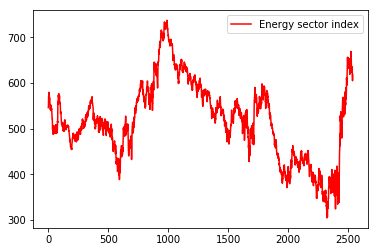

In [63]:
plt.plot(obs, OHLC_avg, 'r', label = 'Energy sector index')

plt.legend(loc = 'upper right')
plt.show()

In [64]:
np.mean(OHLC_avg)


energyClosing    517.92855
dtype: float64

In [65]:
np.any(np.isnan(OHLC_avg))

False

In [66]:
np.all(np.isfinite(OHLC_avg))

True

In [67]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]


In [68]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)


In [69]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)


In [70]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [71]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/5
 - 452s - loss: 0.0056
Epoch 2/5
 - 448s - loss: 3.7689e-04
Epoch 3/5
 - 436s - loss: 3.4010e-04
Epoch 4/5
 - 440s - loss: 3.3402e-04
Epoch 5/5
 - 448s - loss: 3.3134e-04


In [80]:
#nsamples, nx, ny = trainX.shape
#d2_train_datasetX = trainX.reshape((nsamples,nx*ny))
nsamples2, nx2, ny2 = trainY.shape
d2_train_datasetY = trainY.reshape((nsamples,nx*ny))

ValueError: not enough values to unpack (expected 3, got 2)

In [81]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

In [ ]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

In [ ]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [ ]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

In [ ]:
next_val